In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 1. Defining the funnel distribution

In [2]:
class funnel():
    def __init__(self, y_std=1):
        self.y_dist = Normal(0, y_std)
    
    def log_prob_normal(self, mu, scale, x):
        cov = scale*scale
        a = -0.5 * (np.log(2 * np.pi) + torch.log(cov))
        b =  -0.5 * (x - mu) * (x - mu) / cov
        return a + b
    
    def log_prob(self, data):
        x = data[:, 0]
        y = data[:, 1]
        y_log_pdf = self.y_dist.log_prob(y)
        x_log_pdf = self.log_prob_normal(0.0, self.x_std(y), x)
        return x_log_pdf + y_log_pdf
    
    def x_std(self, y):
        return torch.exp(y) / 10
    
    def sample(self, n_samples):
        y = self.y_dist.sample([n_samples])
        x = torch.randn_like(y) * self.x_std(y)
        return torch.vstack([x, y]).T 
    
funne_dist = funnel()

### 2. Probability Flow ODE

#### 2.1 Building the model

In [3]:
# define a MLP discriminator
class Discriminator(nn.Module):
    def __init__(self, d_input_dim=2):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return self.fc3(x)

In [4]:
# build network
data_dim = 2
# loss
criterion = nn.BCEWithLogitsLoss()

D_logit = Discriminator().to(device)
xs = (torch.randn([1024, 2])*0.5 + torch.tensor([0.0, 2.0])).to(device)
xs.requires_grad=True

# optimizer
D_optimizer = optim.Adam(D_logit.parameters(), lr = 0.001)

'''
One can also use SGD optimizer for xs which corresponds
to the standard forward Euler approach, but it works very slow.
'''
#G_optimizer = optim.Adam([xs], lr = 0.001)
G_optimizer = optim.SGD([xs], lr = 0.001)

def train_per_step(batch_size=1024):
    D_losses, G_losses = [], []
    #idx = np.random.choice(data.shape[0], batch_size, replace=False)
    x = funne_dist.sample(batch_size).to(device)

    #==============Train the discriminator===============#
    D_optimizer.zero_grad()
    # train discriminator on p
    x_real, y_real = x.view(-1, data_dim), torch.ones(batch_size, 1).to(device)
    real_loss = criterion(D_logit(x_real), y_real)

    # train discriminator on q_i
    idx = np.random.choice(xs.shape[0], batch_size, replace=False)
    x_fake, y_fake = xs[idx], torch.zeros(batch_size, 1).to(device)
    fake_loss = criterion(D_logit(x_fake), y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = real_loss + fake_loss
    D_loss.backward()
    D_optimizer.step()

    #==============Update particles===============#
    G_optimizer.zero_grad()
    
    # update all particles
    logit_xs = D_logit(xs)
    # batch gradient for each particle
    ''' torch.sum(logit_xs) is the sum for all log ratios,
            back-propogating the sum returns the gradient for each particle.
    '''
    
    G_loss = -torch.sum(logit_xs)
    G_loss.backward()
    G_optimizer.step()

    D_losses.append(D_loss.data.item())
    G_losses.append(G_loss.data.item())
    return torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))

### 3. Simulation of the ODE

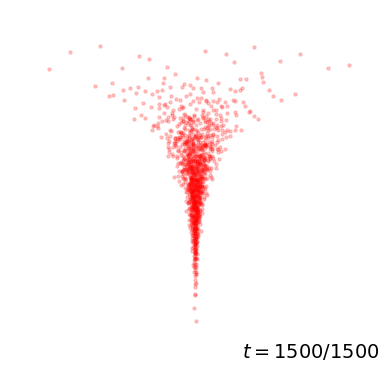

[1500/1500]: loss_d: 1.311, loss_g: 175.210, D_lr: 0.000741, G_lr: 0.000741


In [5]:
n_iters = 1500
scheduler_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=G_optimizer, gamma=0.9998)
scheduler_D = torch.optim.lr_scheduler.ExponentialLR(optimizer=D_optimizer, gamma=0.9998)
flows = []

fig, ax = plt.subplots(figsize=(4, 4))
scatter_plot = ax.scatter(xs.detach().cpu()[:, 0], xs.detach().cpu()[:, 1], s=5, alpha=0.2, color='red')
time_text = ax.text(1.0, -3.5, '$t=0$', fontsize=14) 
ax.axis('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()

clear_output(wait=True)
display(fig)


for i in range(0, n_iters+1):
    D_loss, G_loss = train_per_step()
    particles_t = xs.cpu().detach()
    scatter_plot.set_offsets(particles_t)
    time_text.set_text(f'$t={i}/{n_iters}$')
    flows.append(particles_t)
    clear_output(wait=True)
    display(fig)
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f, D_lr: %.6f, G_lr: %.6f' % (
            i, n_iters, D_loss, G_loss, scheduler_D.get_last_lr()[0], scheduler_G.get_last_lr()[0]))
    scheduler_G.step()
    scheduler_D.step()
plt.close()

### 4. Generating animation

In [6]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import LineCollection
from tqdm import tqdm
 

def update(frame):
    scatter_plot.set_offsets(flows[frame])
    time_text.set_text(f'$t={frame}/{n_iters}$')
## Generate gif 
ani = FuncAnimation(fig=fig, func=update, frames=tqdm(range(0, len(flows), 1)), interval=1)
writer = PillowWriter(fps=40)  
ani.save("funnel_ode.gif", writer=writer)  


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1500/1501 [00:30<00:00, 112.03it/s]